## Imports

In [1]:
## Our standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import missingno as miss


## Preprocessing tools
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

## Models & evaluation metrics
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import joblib, os

## setting random state for reproducibility
SEED = 321
np.random.seed(SEED)
## Matplotlib style
fav_style = ('ggplot','tableau-colorblind10')
fav_context  ={'context':'notebook', 'font_scale':1.1}
plt.style.use(fav_style)
sns.set_context(**fav_context)
plt.rcParams['savefig.transparent'] = False
plt.rcParams['savefig.bbox'] = 'tight'



## Custom Functions

In [34]:
def find_outliers_Z(data, verbose=True):
    import pandas as pd
    import numpy as np
    import scipy.stats as stats
    outliers = np.abs(stats.zscore(data))>3
    
    
    if verbose:
        n = len(outliers)
        print(f"- {outliers.sum():,} outliers found in {data.name} out of {n:,} rows ({outliers.sum()/n*100:.2f}%) using Z-scores.")

    outliers = pd.Series(outliers, index=data.index, name=data.name)
    return outliers


def find_outliers_IQR(data, verbose=True):
    import pandas as pd
    import numpy as np
    q3 = np.quantile(data,.75)
    q1 = np.quantile(data,.25)

    IQR = q3 - q1
    upper_threshold = q3 + 1.5*IQR
    lower_threshold = q1 - 1.5*IQR
    
    outliers = (data<lower_threshold) | (data>upper_threshold)
    if verbose:
        n = len(outliers)
    
    
        print(f"- {outliers.sum():,} outliers found in {data.name} out of {n:,} rows ({outliers.sum()/n*100:.2f}%) using IQR.")
        
    outliers = pd.Series(outliers, index=data.index, name=data.name)
    return outliers




def remove_outliers(df_,method='iqr', subset=None, verbose=2):
    """Returns a copy of the input df with outleirs removed from all
    columns using the selected method (either 'iqr' or 'z'/'zscore')
    
    Arguments:
        df_ (Frame): Dataframe to copy and remove outleirs from
        method (str): Method of outlier removal. Options are 'iqr' or 'z' (default is 'iqr')
        subset (list or None): List of column names to remove outliers from. If None, uses all numeric columns.
        verbose (bool, int): If verbose==1, print only overall summary. If verbose==2, print detailed summary"""
    import pandas as pd
    ## Make a cope of input dataframe  
    df = df_.copy()
    
    ## Set verbose_func for calls to outleir funcs
    if verbose==2:
        verbose_func = True
    else:
        verbose_func=False
        
    ## Set outlier removal function and name
    if method.lower()=='iqr':
        find_outlier_func = find_outliers_IQR
        method_name = "IQR rule"
    elif 'z' in method.lower():
        find_outlier_func = find_outliers_Z
        method_name = 'Z_score rule'
    else:
        raise Exception('[!] Method must be either "iqr" or "z".')
        
    ## Set list of cols to remove outliers from
    if subset is None:
        col_list = df.select_dtypes('number').columns
    elif isinstance(subset,str):
        col_list = [subset]
    elif isinstance(subset, list):
        col_list = subset
    else:
        raise Exception("[!] subset must be None, a single string, or a list of strings.")

    

    
    ## Empty dict for both types of outliers
    outliers = {}

    ## Use both functions to see the comparison for # of outliers
    for col in col_list:
        idx_outliers = find_outlier_func(df[col],verbose=verbose_func)
        outliers[col] = idx_outliers

    
    ## Getting final df of all outliers to get 1 final T/F index
    outliers_combined = pd.DataFrame(outliers).any(axis=1)
    
    if verbose:
        n = len(outliers_combined)
        print(f"\n[i] Overall, {outliers_combined.sum():,} rows out of {n:,}({outliers_combined.sum()/n*100:.2f}%) were removed as outliers using {method_name}.")
    
    
    # remove_outliers 
    df_clean = df[~outliers_combined].copy()
    return df_clean
      
    
    
def evaluate_ols(result,X_train_df, y_train, show_summary=True):
    """Plots a Q-Q Plot and residual plot for a statsmodels OLS regression.
    """
    import matplotlib.pyplot as plt
    import statsmodels.api as sm
    try:
        display(result.summary())
    except:
        pass
    
    ## save residuals from result
    y_pred = result.predict(X_train_df)
    resid = y_train - y_pred
    
    fig, axes = plt.subplots(ncols=2,figsize=(12,5))
    
    ## Normality 
    sm.graphics.qqplot(resid,line='45',fit=True,ax=axes[0]);
    
    ## Homoscedasticity
    ax = axes[1]
    ax.scatter(y_pred, resid, edgecolor='white',lw=1)
    ax.axhline(0,zorder=0)
    ax.set(ylabel='Residuals',xlabel='Predicted Value');
    plt.tight_layout()
    
    
    
def plot_residuals(model,X_test_df, y_test,figsize=(12,5)):
    """Plots a Q-Q Plot and residual plot for a statsmodels OLS regression.
    
    """
    ## Make predictions and calculate residuals
    y_pred = model.predict(X_test_df)
    resid = y_test - y_pred
    
    fig, axes = plt.subplots(ncols=2,figsize=figsize)
    
    ## Normality 
    sm.graphics.qqplot(resid, line='45',fit=True,ax=axes[0]);
    
    ## Homoscedascity
    ax = axes[1]
    ax.scatter(y_pred, resid, edgecolor='white',lw=0.5)
    ax.axhline(0,zorder=0)
    ax.set(ylabel='Residuals',xlabel='Predicted Value');
    plt.tight_layout()
    
def evaluate_regression(model, X_train,y_train, X_test, y_test,for_slides=True): 
    """Evaluates a scikit learn regression model using r-squared and RMSE
    FOR SLIDES VERS DOES MULTIPLE PRINT STATEMENTS FOR VERTICAL DISPLAY OF INFO"""
    
    ## Training Data
    y_pred_train = model.predict(X_train)
    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train, y_pred_train, 
                                            squared=False)
    mae_train = metrics.mean_absolute_error(y_train, y_pred_train)
    

    ## Test Data
    y_pred_test = model.predict(X_test)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test, y_pred_test, 
                                            squared=False)
    mae_test = metrics.mean_absolute_error(y_test, y_pred_test)
    
    if for_slides:
        df_version =[['Split','R^2','MAE','RMSE']]
        df_version.append(['Train',r2_train, mae_train, rmse_train])
        df_version.append(['Test',r2_test, mae_test, rmse_test])
        df_results = pd.DataFrame(df_version[1:], columns=df_version[0])
        df_results = df_results.round(2)
        display(df_results.style.hide(axis='index').format(precision=2, thousands=','))
        
    else: 
        print(f"Training Data:\tR^2 = {r2_train:,.2f}\tRMSE = {rmse_train:,.2f}\tMAE = {mae_train:,.2f}")
        print(f"Test Data:\tR^2 = {r2_test:,.2f}\tRMSE = {rmse_test:,.2f}\tMAE = {mae_test:,.2f}")
        
def get_coefficients(lin_reg):
    coeffs = pd.Series(lin_reg.coef_, index= lin_reg.feature_names_in_)
    coeffs.loc['intercept'] = lin_reg.intercept_
    return coeffs

def plot_coeffs(coeffs, top_n=None,  figsize=(4,5), intercept=False, 
                annotate=False, ha='left',va='center', size=12, xytext=(4,0),
                  textcoords='offset points'):
    """Plots the top_n coefficients from a Series, with optional annotations."""
    if (intercept==False) & ('intercept' in coeffs.index):
        coeffs = coeffs.drop('intercept')
    if top_n==None:
        ## sort all features and set title
        plot_vals = coeffs#.sort_values()
        title = "All Coefficients - Ranked by Magnitude"
    else:
        ## rank the coeffs and select the top_n
        coeff_rank = coeffs.abs().rank().sort_values(ascending=False)
        top_n_features = coeff_rank.head(top_n)
        plot_vals = coeffs.loc[top_n_features.index].sort_values()
        ## sort features and keep top_n and set title
        title = f"Top {top_n} Largest Coefficients"
    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Coefficient', 
           ylabel='Feature Names', 
           title=title)
    ax.axvline(0, color='k')
    
    if annotate==True:
        annotate_hbars(ax, ha=ha,va=va,size=size,xytext=xytext,
                       textcoords=textcoords)
    ## return ax in case want to continue to update/modify figure
    return ax

def annotate_hbars(ax, ha='left',va='center',size=12,  xytext=(4,0),
                  textcoords='offset points'):
    for bar in ax.patches:
    
        ## calculate center of bar
        bar_ax = bar.get_y() + bar.get_height()/2
        ## get the value to annotate
        val = bar.get_width()
        if val < 0:
            val_pos = 0
        else:
            val_pos = val
        # ha and va stand for the horizontal and vertical alignment
        ax.annotate(f"{val:.3f}", (val_pos,bar_ax), ha=ha,va=va,size=size,
                        xytext=xytext, textcoords=textcoords)

## Load Data

In [3]:

food_sales_df = pd.read_excel('Data/sales_predictions.xlsx')
food_sales_df.info()
food_sales_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


## Data Cleaning

In [4]:
#check for duplicates
food_sales_df.duplicated().sum()

0

In [5]:

food_sales_df.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [6]:
# check for number of unique values in each column
food_sales_df.nunique()

Item_Identifier              1559
Item_Weight                   415
Item_Fat_Content                5
Item_Visibility              7880
Item_Type                      16
Item_MRP                     5938
Outlet_Identifier              10
Outlet_Establishment_Year       9
Outlet_Size                     3
Outlet_Location_Type            3
Outlet_Type                     4
Item_Outlet_Sales            3493
dtype: int64

In [7]:

# find and fix inconsistent categories
food_sales_df["Item_Fat_Content"].value_counts()
food_sales_df["Item_Fat_Content"] = food_sales_df["Item_Fat_Content"].replace('LF', 'Low Fat')
food_sales_df["Item_Fat_Content"] = food_sales_df["Item_Fat_Content"].replace('low fat', 'Low Fat')
food_sales_df["Item_Fat_Content"] = food_sales_df["Item_Fat_Content"].replace('reg', 'Regular')
food_sales_df["Item_Fat_Content"].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

In [8]:
!python --version
print(f"sklearn version: {sklearn.__version__}")

Python 3.9.15
sklearn version: 1.1.3


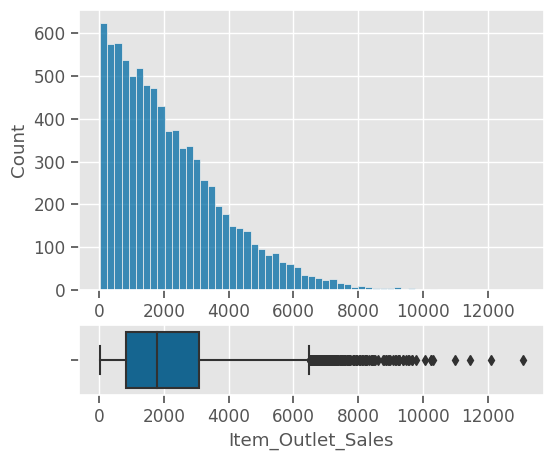

In [9]:
target = 'Item_Outlet_Sales'

grid_spec = {'height_ratios':[0.8,0.2]}
fig, axes = plt.subplots(nrows=2, figsize=(6,5), gridspec_kw=grid_spec)

sns.histplot(data=food_sales_df, x=target,ax=axes[0])
sns.boxplot(data=food_sales_df, x=target, ax=axes[1]);

## Model Validation Split

In [10]:

#Set target
target = 'Item_Outlet_Sales'
X = food_sales_df.drop(columns = target)
y = food_sales_df[target]

## train-test-split with random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=SEED)
X_train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
8269,FDI60,7.220,Regular,0.064142,Baking Goods,61.2510,OUT010,1998,NaN,Tier 3,Grocery Store
7604,DRD25,6.135,Low Fat,0.079294,Soft Drinks,111.2860,OUT018,2009,Medium,Tier 3,Supermarket Type2
2762,NCP18,12.150,Low Fat,0.028593,Household,151.0708,OUT035,2004,Small,Tier 2,Supermarket Type1
6464,NCS30,5.945,Low Fat,0.093009,Household,127.8652,OUT035,2004,Small,Tier 2,Supermarket Type1
4707,FDI08,18.200,Regular,0.066285,Fruits and Vegetables,247.2092,OUT035,2004,Small,Tier 2,Supermarket Type1


## Preprocessing

In [11]:
## Make numeric preprocessing pipeline
num_sel = make_column_selector(dtype_include='number')
num_pipe = make_pipeline(SimpleImputer(strategy='mean'))
num_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer())])

In [12]:
## Make categorical preprocessing pipeline
cat_sel = make_column_selector(dtype_include='object')
cat_pipe = make_pipeline(SimpleImputer(strategy='constant',
                                       fill_value='MISSING'),
                         OneHotEncoder(handle_unknown='ignore', sparse=False))

In [13]:
## make the preprocessing column transformer
preprocessor = make_column_transformer((num_pipe, num_sel),
                                       (cat_pipe,cat_sel),)
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x136391ca0>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x13679c9d0>)])

In [14]:
## make the preprocessing column transformer WITH CORRECT ARGS!
preprocessor = make_column_transformer((num_pipe, num_sel),
                                       (cat_pipe,cat_sel),
                                      verbose_feature_names_out=False)
preprocessor.fit(X_train)
X_train_df = pd.DataFrame(preprocessor.transform(X_train),
                          columns=preprocessor.get_feature_names_out(),
                         index=X_train.index)
X_test_df = pd.DataFrame(preprocessor.transform(X_test),
                          columns=preprocessor.get_feature_names_out(),
                         index=X_test.index)
display(X_train_df)

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Identifier_DRA12,Item_Identifier_DRA24,Item_Identifier_DRA59,Item_Identifier_DRB01,Item_Identifier_DRB13,Item_Identifier_DRB24,...,Outlet_Size_MISSING,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
8269,7.220000,0.064142,61.2510,1998.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
7604,6.135000,0.079294,111.2860,2009.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2762,12.150000,0.028593,151.0708,2004.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
6464,5.945000,0.093009,127.8652,2004.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4707,18.200000,0.066285,247.2092,2004.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3482,12.822634,0.012216,162.7894,1985.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
8360,11.500000,0.014884,174.5080,1999.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
5929,5.110000,0.034945,161.1210,2002.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4220,6.550000,0.034800,157.5288,2007.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


## Linear Regression

In [15]:
# instantiate the model
lin_reg = LinearRegression()
lin_reg.fit(X_train_df,y_train)
evaluate_regression(lin_reg, X_train_df, y_train, X_test_df,y_test)

Split,R^2,MAE,RMSE
Train,0.67,725.47,973.13
Test,"-682,085,984,864,704.50","2,912,117,874.76","45,870,252,829.25"


In [16]:
def get_coefficients(lin_reg):
    coeffs = pd.Series(lin_reg.coef_, index= lin_reg.feature_names_in_)
    coeffs.loc['intercept'] = lin_reg.intercept_
    return coeffs

In [17]:
coeffs = get_coefficients(lin_reg)
coeffs

Item_Weight                     -2.414054e+00
Item_Visibility                 -7.949682e+02
Item_MRP                        -1.108004e+01
Outlet_Establishment_Year       -2.907340e+11
Item_Identifier_DRA12            1.393303e+12
                                     ...     
Outlet_Type_Grocery Store       -7.057861e+12
Outlet_Type_Supermarket Type1    4.331594e+11
Outlet_Type_Supermarket Type2    7.339258e+11
Outlet_Type_Supermarket Type3   -2.500916e+12
intercept                        5.828107e+14
Length: 1598, dtype: float64

In [18]:
## rank the coeffs and select the top_n
top_n=15
coeff_rank = coeffs.abs().rank().sort_values(ascending=False)
top_n_features = coeff_rank.head(top_n)
coeffs_plot = coeffs.loc[top_n_features.index].sort_values()
coeffs_plot

Outlet_Type_Grocery Store       -7.057861e+12
Outlet_Identifier_OUT046        -4.670603e+12
Outlet_Location_Type_Tier 3     -3.820079e+12
Outlet_Type_Supermarket Type3   -2.500916e+12
Outlet_Identifier_OUT035        -2.456402e+12
Item_Type_Soft Drinks           -2.250121e+12
Item_Type_Hard Drinks           -1.467570e+12
Item_Identifier_DRE60            1.393303e+12
Item_Identifier_DRF60            1.393303e+12
Item_Identifier_DRF36            1.393303e+12
Outlet_Size_Small                2.637779e+12
Outlet_Identifier_OUT027         2.646960e+12
Outlet_Identifier_OUT018         6.389735e+12
Outlet_Identifier_OUT010         1.005430e+13
intercept                        5.828107e+14
dtype: float64

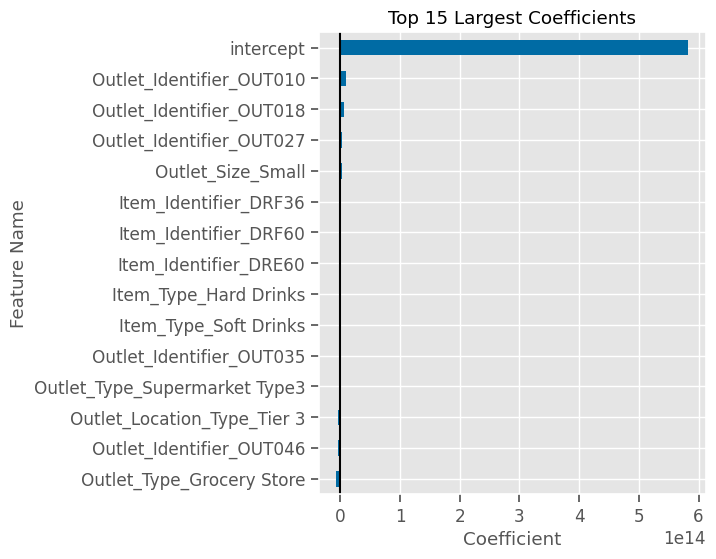

In [19]:
## sort features and keep top_n and set title
ax = coeffs_plot.sort_values().plot(kind='barh',figsize=(5,6))
ax.axvline(0,color='k');
ax.set(title = f"Top {top_n} Largest Coefficients",ylabel="Feature Name",
      xlabel='Coefficient');

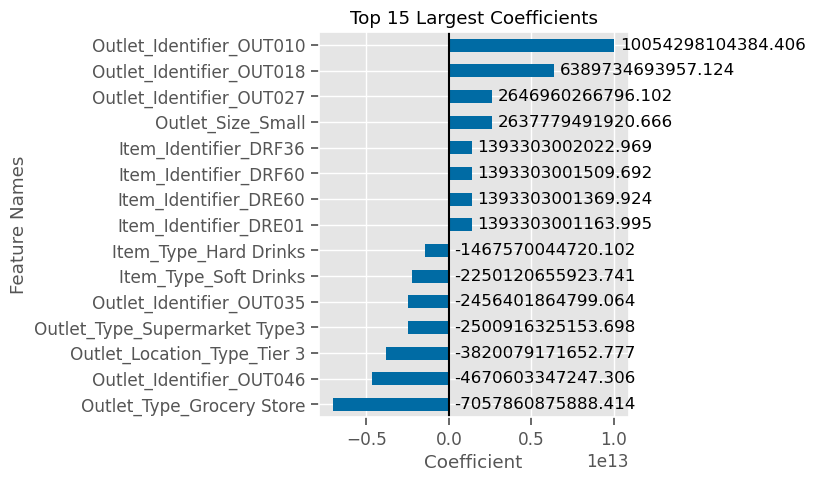

In [35]:
plot_coeffs(coeffs,top_n=15,intercept=False,annotate=True)
plt.savefig('Top 15 Coefficients');

- Top 3 Postive Coefficients:
 - Outlet Identifier OUT010
 - Outlet Identifier OUT018
 - Outlet Identifier OUT027
 
- Top 3 Negative Coefficients:
    - Outlet Type Grocery Store
    - Outlet Identifier OUT046
    - Outlet Location Type Tier 3

## Random Forest Regressor

In [21]:
rf_reg = RandomForestRegressor()
rf_reg.fit(X_train_df,y_train)
evaluate_regression(rf_reg, X_train_df, y_train, 
                    X_test_df, y_test)

Split,R^2,MAE,RMSE
Train,0.94,291.98,422.78
Test,0.56,817.74,"1,162.59"


In [22]:
## Saving the coefficients
importances = pd.Series(rf_reg.feature_importances_, index= rf_reg.feature_names_in_)
importances

Item_Weight                      0.030208
Item_Visibility                  0.057832
Item_MRP                         0.404000
Outlet_Establishment_Year        0.025913
Item_Identifier_DRA12            0.000053
                                   ...   
Outlet_Location_Type_Tier 3      0.002532
Outlet_Type_Grocery Store        0.196758
Outlet_Type_Supermarket Type1    0.001818
Outlet_Type_Supermarket Type2    0.001083
Outlet_Type_Supermarket Type3    0.027465
Length: 1597, dtype: float64

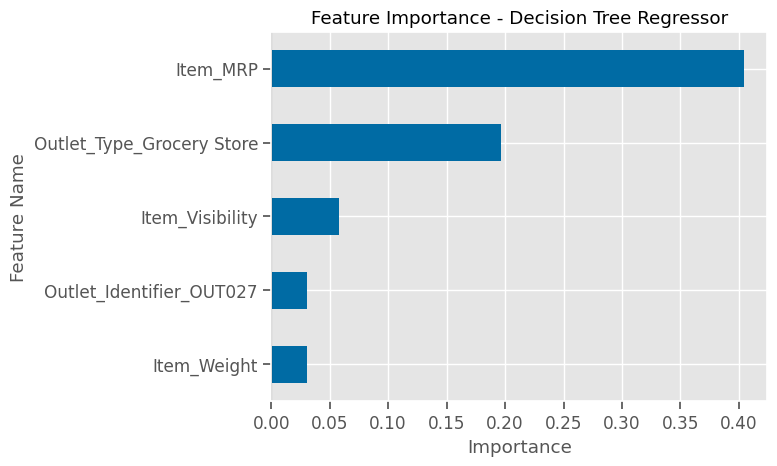

In [33]:
ax = importances.sort_values().tail(5).plot(kind='barh')#,figsize=(6,4))
ax.axvline(0, color='k')
ax.set(title='Feature Importance - Decision Tree Regressor',ylabel="Feature Name",
      xlabel='Importance')
plt.savefig('Feature Importance - Decision Tree Regressor');

In [24]:
## Saving the coefficients
importances = pd.Series(rf_reg.feature_importances_, index= rf_reg.feature_names_in_)
importances

Item_Weight                      0.030208
Item_Visibility                  0.057832
Item_MRP                         0.404000
Outlet_Establishment_Year        0.025913
Item_Identifier_DRA12            0.000053
                                   ...   
Outlet_Location_Type_Tier 3      0.002532
Outlet_Type_Grocery Store        0.196758
Outlet_Type_Supermarket Type1    0.001818
Outlet_Type_Supermarket Type2    0.001083
Outlet_Type_Supermarket Type3    0.027465
Length: 1597, dtype: float64

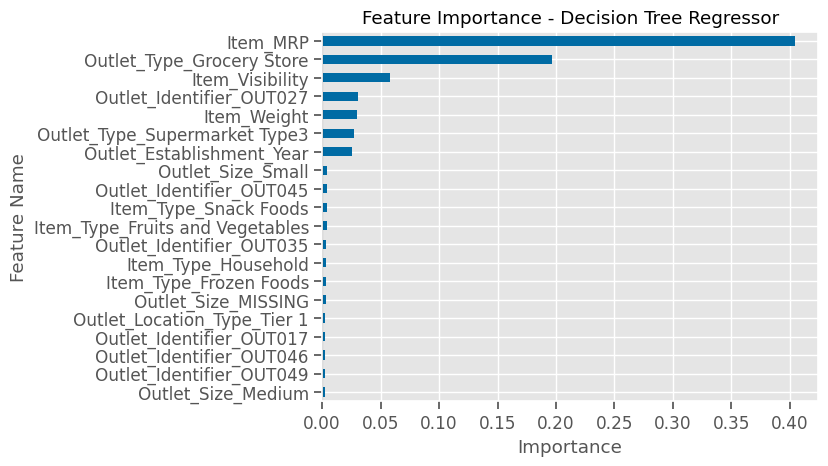

In [25]:
# Create plot
ax = importances.sort_values().tail(20).plot(kind='barh')#,figsize=(6,4))
ax.axvline(0, color='k')
ax.set(title='Feature Importance - Decision Tree Regressor',ylabel="Feature Name",
      xlabel='Importance');

- Top 5 Important Features (used repeatedly by the model during the training process and does not indicate positive or negative impact)
    - Item MRP
    - Outlet Type Grocery Store
    - Item Visibility
    - Outet Identifier OUT027
    - Item Weight

## Joblib

In [26]:
X_train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
8269,FDI60,7.220,Regular,0.064142,Baking Goods,61.2510,OUT010,1998,NaN,Tier 3,Grocery Store
7604,DRD25,6.135,Low Fat,0.079294,Soft Drinks,111.2860,OUT018,2009,Medium,Tier 3,Supermarket Type2
2762,NCP18,12.150,Low Fat,0.028593,Household,151.0708,OUT035,2004,Small,Tier 2,Supermarket Type1
6464,NCS30,5.945,Low Fat,0.093009,Household,127.8652,OUT035,2004,Small,Tier 2,Supermarket Type1
4707,FDI08,18.200,Regular,0.066285,Fruits and Vegetables,247.2092,OUT035,2004,Small,Tier 2,Supermarket Type1


In [27]:
evaluate_regression(lin_reg,X_train_df,y_train, X_test_df, y_test)

Split,R^2,MAE,RMSE
Train,0.67,725.47,973.13
Test,"-682,085,984,864,704.50","2,912,117,874.76","45,870,252,829.25"


In [28]:
evaluate_regression(rf_reg,X_train_df,y_train, X_test_df, y_test)

Split,R^2,MAE,RMSE
Train,0.94,291.98,422.78
Test,0.56,817.74,"1,162.59"


In [29]:
## creating a dictionary of all of the variables to save for later
export = {'X_train':X_train,
         'y_train':y_train,
         'X_test':X_test,
         'y_test':y_test,
          'preprocessor':preprocessor,
         'LinearRegression': lin_reg,
          'RandomForestRegressor':rf_reg
         }

In [30]:
folder = "Models/"
os.makedirs(folder, exist_ok=True)


In [31]:
fname = folder+'best-models.joblib'
joblib.dump(export, fname)

['Models/best-models.joblib']